<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Data Wrangling</h1><h2>Assignment 2</h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

#### <center> Kiara Avendano ( s10219186A )
##### <center> Assignment 2


# Links <a id="top"></a>

## 1 [Loading](#dl)
   - [1.1 Exploring](#de)

## 2 [Wrangling](#dw)
   - [2.1 Results](#results)
   - [2.2 Status](#status)
   - [2.3 Qualifiers](#qualifiers)
   - [2.4 Laps](#laps)
   - [2.5 Drivers](#drivers)
   - [2.6 Races](#race)
   - [2.7 Circuits](#circuits)
   - [2.8 Final](#final)

## 3 [Cleansing](#dc)
   - [3.1 Missing Value Imputation](#mvi)
   
## 4 [Model](#ai)
   - [4.1 Naive Baseline](#naive)
   - [4.2 Final Model](#rfm)
   
## 5 [Report](#report)

## Loading <a id="dl"></a>

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import datetime

In [2]:
results = pd.read_csv("./f1db_csv_mod/results_mod.csv",na_values = r"\N")
status = pd.read_csv("./f1db_csv_mod/status_mod.csv",na_values = r"\N")

In [3]:
qualifiers = pd.read_csv("./f1db_csv_mod/qualifying_mod.csv",na_values = r"\N")
laps = pd.read_csv("./f1db_csv_mod/lap_times_mod.csv",na_values = r"\N")

In [4]:
drivers = pd.read_csv("./f1db_csv_mod/drivers_mod.csv",na_values = r"\N")
drivers = drivers.loc[:,["driverId","dob"]]

In [5]:
races = pd.read_csv("./f1db_csv_mod/races_mod.csv",na_values = r"\N")
races = races.iloc[:,[0,1,2,4]]

In [6]:
# process the circuit information
circuits = pd.read_csv("./f1db_csv_mod/circuits_mod.csv",na_values = r"\N")
circuits = circuits.loc[:,["circuitId", "name","lat","lng","alt"]]

[Back to links](#top)

### Exploring <a id="de"></a>

In [7]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,34:50.6,5690616.0,39.0,2.0,01:27.5,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,5.478,5696094.0,41.0,3.0,01:27.7,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,8.163,5698779.0,41.0,5.0,01:28.1,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,17.181,5707797.0,58.0,7.0,01:28.6,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,18.014,5708630.0,43.0,1.0,01:27.4,218.385,1


In [8]:
status.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [9]:
qualifiers.head()

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [10]:
laps.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,01:38.1,98109
1,841,20,2,1,01:33.0,93006
2,841,20,3,1,01:32.7,92713
3,841,20,4,1,01:32.8,92803
4,841,20,5,1,01:32.3,92342


In [11]:
drivers.head()

,driverId,dob
0,1,1985-01-07
1,2,1977-05-10
2,3,1985-06-27
3,4,1981-07-29
4,5,1981-10-19


In [12]:
races.head()

,raceId,round,circuitId,date
0,1,1,1,3/29/2009
1,2,2,2,4/5/12009
2,3,3,17,4/19/2009
3,4,4,3,4/26/2009
4,5,5,4,5/10/2009


In [13]:
circuits.head()

,circuitId,name,lat,lng,alt
0,1,Albert Park Grand Prix Circuit,-37.84970,144.96800,10.0
1,2,Sepang International Circuit,2.76083,101.73800,18.0
2,3,Bahrain International Circuit,26.03250,50.51060,7.0
3,4,Circuit de Barcelona-Catalunya,41.57000,2.26111,109.0
4,5,Istanbul Park,40.95170,29.40500,130.0


[Back to links](#top)

## Wrangling <a id="dw"></a>

In [14]:
def create_target(df1):
    # drop rows that are not classified
    df = df1.loc[df1["status"] != "Not classified",:]
    # group the statuses
    success = ["Finished"]
    dq = ['Disqualified', '+1 Lap', '+2 Laps', '+3 Laps',
          '+4 Laps', '+5 Laps', '+6 Laps', '+7 Laps', '+8 Laps', 
          '+9 Laps', 'Retired', '+11 Laps', '+17 Laps', '+42 Laps', 
          '+13 Laps', 'Withdrew', '+12 Laps', '+26 Laps', '107% Rule' , 
          'Did not qualify', '+10 Laps' , 'Underweight', 'Excluded', 
          'Did not prequalify', 'Driver unwell', '+14 Laps', '+15 Laps',
           '+25 Laps', '+18 Laps', '+22 Laps', '+16 Laps', '+24 Laps',
           '+29 Laps', '+23 Laps', '+21 Laps', '+44 Laps',
           '+30 Laps', '+19 Laps', '+46 Laps', '+20 Laps', '+49 Laps',
          '+38 Laps', 'Illness', 'Eye injury']
    d_i = ['Accident', 'Collision', 'Spun off', 'Fire', 'Injured', 
           'Injury', 'Fatal accident', 'Collision damage', 'Debris',
           'Damage']
    s_i = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics',
           'Electrical', 'Radiator',
           'Suspension', 'Brakes', 'Differential', 'Overheating',
           'Mechanical', 'Tyre', 'Driver Seat', 'Puncture', 'Driveshaft',
           'Fuel pressure', 'Front wing', 'Water pressure',
           'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
           'Electronics', 'Broken wing', 'Heat shield fire', 'Exhaust',
           'Oil leak', 'Wheel rim', 'Water leak', 'Fuel pump',
           'Track rod', 'Oil pressure', 'Engine fire', 'Engine misfire', 
           'Tyre puncture', 'Out of fuel', 'Wheel nut', 'Pneumatics', 
           'Handling', 'Rear wing',
           'Wheel bearing', 'Physical', 'Fuel system', 'Oil line', 'Fuel rig',
           'Supercharger',
           'Launch control', 'Fuel', 'Power loss', 'Vibrations', 'Safety',
           'Drivetrain', 'Ignition' , 'Chassis', 'Battery', 'Stalled',
           'Halfshaft', 'Safety concerns', 'Not restarted', 'Alternator', 
           'Crankshaft', 'Safety belt', 'Oil pump',   'Fuel leak', 'Injection',
           'Distributor', 'Turbo', 'CV joint', 'Water pump', 'Spark plugs', 
           'Fuel pipe', 'Oil pipe', 'Axle', 'Water pipe', 'Magneto',
           'Power Unit', 'ERS', 'Brake duct', 'Seat'
    ]
    
    conditions = [
        df["status"].isin(success),
        df["status"].isin(dq),
        df["status"].isin(d_i),
        df["status"].isin(s_i)
    ]
    choices= [0,1,2,3]
    tar = np.select(conditions, choices, default = 999)
    df["target"] = tar
    return df

def tts(df,target = "target"):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop(target, axis=1), df[target], test_size=0.3, random_state = 1)
    return X_train, X_test, y_train, y_test

def lap_ms(df, col):
    # create a series splitting the miuntes and seconds
    MS = pd.DataFrame(df[col].str.split(":", expand = True))
    MS[0] = pd.to_numeric(MS[0])
    MS[1] = pd.to_numeric(MS[1])
    # conversion
    df[col] = ((MS.iloc[:,0] * 60) + MS.iloc[:,1]) * 1000

def fillNA(df,col1,col2):
    df[col1] = df[col1].fillna(df[col2])

# lagshift
# the new columns added are information known even before the grand prix weekend starts
def lag_cols(df, columns, lag = 1):
    for i in columns:
        new_col = "prev_" + i
        df[new_col] = df[i].shift(lag)
    df = df.groupby('driverId').apply(lambda group: group.iloc[1:])
    df.reset_index(drop = True, inplace = True)
    return df

### Results <a id="results"></a>

In [15]:
results["prev_champion "] = np.where(results["number"] == 1, 1,0)

In [16]:
results.drop(columns = ["position","positionText","time","number"], inplace = True)

In [17]:
lap_ms(results,"fastestLapTime")

[Back to links](#top)

### Status <a id="status"></a>

In [18]:
status = create_target(status)

C:\Users\Kayen\AppData\Local\Temp/ipykernel_16376/2599796575.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = tar


[Back to links](#top)

### Qualifiers <a id="qualifiers"></a>

In [19]:
lap_ms(qualifiers, "q1")
lap_ms(qualifiers, "q2")
lap_ms(qualifiers, "q3")

In [20]:
qualifiers.drop(columns = ["qualifyId","constructorId","number"], inplace  = True)

[Back to links](#top)

### Laps <a id="laps"></a>

In [21]:
lap_ms(laps, "time")
laps.drop(columns = "milliseconds",inplace = True)

In [22]:
fastest_L = laps.groupby([ "driverId", "raceId"])["time"].min()
fastest_L = fastest_L.reset_index()
fastest_L = pd.merge(fastest_L, laps, on =["driverId", "raceId","time"])
fastest_L.drop_duplicates(["driverId", "raceId"], inplace = True)
fastest_L.drop(columns = "position", inplace = True)

# get average time taken for each lap
average_L = laps.groupby(["driverId", "raceId"])["time"].mean()
average_L = average_L.reset_index()
average_L.columns =["driverId", "raceId", "avg_lap"]

In [23]:
fastest_L.head()

,driverId,raceId,time,lap
0,1,1,89000.0,39
1,1,2,99100.0,17
2,1,3,114700.0,39
3,1,4,94900.0,13
4,1,5,83800.0,29


In [24]:
average_L.head()

,driverId,raceId,avg_lap
0,1,1,97560.344828
1,1,2,109396.774194
2,1,3,127417.857143
3,1,4,97024.561404
4,1,5,89855.384615


[Back to links](#top)

### Drivers <a id="drivers"></a>

In [25]:
drivers.dob = pd.to_datetime(drivers.dob)

[Back to links](#top)

### Races <a id="race"></a>

In [26]:
date = races["date"].str.split("/", expand = True)
date[2] = date[2].str.replace("^12","2", regex = True)
date[2] = date[2].str[:4]
date["date"] = date[0] + "-" + date[1] +"-" + date[2]
races.date = pd.to_datetime(date["date"])
races

,raceId,round,circuitId,date
0,1,1,1,2009-03-29
1,2,2,2,2009-04-05
2,3,3,17,2009-04-19
3,4,4,3,2009-04-26
4,5,5,4,2009-05-10
...,...,...,...,...
1075,1092,19,22,2022-10-09
1076,1093,20,69,2022-10-23
1077,1094,21,32,2022-10-30
1078,1095,22,18,2022-11-13


[Back to links](#top)

### Circuits <a id="circuits"></a>

In [27]:
# I will impute in by the right values according to google
circuits.at[77,"alt"] = 13
circuits.at[78,"alt"] = 0
circuits[circuits.alt.isnull()]

,circuitId,name,lat,lng,alt


[Back to links](#top)

### Final <a id="final"></a>

In [28]:
df = pd.merge(results, status, on = "statusId")
df.drop(columns = ["status","statusId"], inplace = True)
df.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,prev_champion,target
0,1,18,1,1,1,1,10.0,58,5690616.0,39.0,2.0,87500.0,218.300,0,0
1,2,18,2,2,5,2,8.0,58,5696094.0,41.0,3.0,87700.0,217.586,0,0
2,3,18,3,3,7,3,6.0,58,5698779.0,41.0,5.0,88100.0,216.719,0,0
3,4,18,4,4,11,4,5.0,58,5707797.0,58.0,7.0,88600.0,215.464,0,0
4,5,18,5,1,3,5,4.0,58,5708630.0,43.0,1.0,87400.0,218.385,0,0


In [29]:
df = pd.merge(df, qualifiers, on = ["raceId", "driverId"], how = "left")
df = pd.merge(df, average_L, on = ["driverId", "raceId"], how = "left")
df = pd.merge(df, fastest_L,  on = ["driverId", "raceId"], how = "left")
fillNA(df,"fastestLap", "lap")
fillNA(df, "fastestLapTime", "time")
df.drop(columns = ["lap","time"], inplace = True)
df

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,prev_champion,target,position,q1,q2,q3,avg_lap
0,1,18,1,1,1,1,10.0,58,5690616.0,39.0,2.0,87500.0,218.300,0,0,1.0,86572.0,85187.0,86714.0,98118.965517
1,2,18,2,2,5,2,8.0,58,5696094.0,41.0,3.0,87700.0,217.586,0,0,5.0,85960.0,85518.0,87236.0,98206.896552
2,3,18,3,3,7,3,6.0,58,5698779.0,41.0,5.0,88100.0,216.719,0,0,7.0,86295.0,86059.0,88687.0,98253.448276
3,4,18,4,4,11,4,5.0,58,5707797.0,58.0,7.0,88600.0,215.464,0,0,12.0,86907.0,86188.0,NaN,98412.068966
4,5,18,5,1,3,5,4.0,58,5708630.0,43.0,1.0,87400.0,218.385,0,0,3.0,85664.0,85452.0,87079.0,98431.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25222,23533,976,815,10,6,15,0.0,39,NaN,37.0,8.0,105600.0,204.670,0,3,6.0,103162.0,102467.0,102111.0,162217.948718
25223,24221,1010,817,4,12,19,0.0,28,NaN,18.0,19.0,89800.0,212.478,0,2,12.0,82921.0,82570.0,NaN,92832.142857
25224,25365,1051,822,131,6,20,0.0,48,NaN,39.0,15.0,87200.0,221.992,0,2,3.0,82016.0,81991.0,81478.0,90837.500000
25225,24764,1037,847,3,15,19,0.0,9,NaN,5.0,18.0,111800.0,225.624,0,2,15.0,103630.0,103468.0,NaN,113966.666667


In [30]:
races = pd.merge(races, circuits, on = "circuitId")
races.drop(columns = "name", inplace = True)
df = pd.merge(races, df, on = "raceId")
df = pd.merge(df, drivers, on ="driverId")
df.head()

,raceId,round,circuitId,date,lat,lng,alt,resultId,driverId,constructorId,...,fastestLapTime,fastestLapSpeed,prev_champion,target,position,q1,q2,q3,avg_lap,dob
0,1,1,1,2009-03-29,-37.8497,144.968,10.0,7554,18,23,...,88000.0,216.891,0,0,1.0,85211.0,84855.0,86202.0,97512.068966,1980-01-19
1,18,1,1,2008-03-16,-37.8497,144.968,10.0,18,18,11,...,NaN,NaN,0,2,13.0,86712.0,86259.0,NaN,NaN,1980-01-19
2,36,1,1,2007-03-18,-37.8497,144.968,10.0,383,18,11,...,88400.0,215.991,0,1,14.0,87540.0,87264.0,NaN,91378.947368,1980-01-19
3,55,3,1,2006-04-02,-37.8497,144.968,10.0,796,18,11,...,87800.0,217.437,0,1,1.0,88081.0,86337.0,85229.0,100278.571429,1980-01-19
4,71,1,1,2005-03-06,-37.8497,144.968,10.0,1149,18,16,...,86300.0,221.316,0,1,8.0,101512.0,90616.0,NaN,90001.785714,1980-01-19


In [31]:
df["age"] = (df["date"] - df["dob"] ) / np.timedelta64(1,"Y")
df["age"] = df["age"].apply(np.floor)

In [32]:
cols = ["points", "milliseconds","fastestLap", 'rank', "fastestLapTime", "fastestLapSpeed", "avg_lap"]
df = df.sort_values(["driverId","date"])

In [33]:
df = lag_cols(df, cols)
df.drop(columns = cols, inplace = True)
df.drop(columns = ["resultId", "raceId", "driverId","constructorId", "circuitId","date","dob"], inplace = True)
df.head()

,round,lat,lng,alt,grid,positionOrder,laps,prev_champion,target,position,...,q2,q3,age,prev_points,prev_milliseconds,prev_fastestLap,prev_rank,prev_fastestLapTime,prev_fastestLapSpeed,prev_avg_lap
0,2,2.76083,101.73800,18.0,4,2,56,0,0,4.0,...,94650.0,96045.0,22.0,6.0,5147365.0,20.0,3.0,86400.0,221.083,88750.000000
1,3,26.03250,50.51060,7.0,2,2,57,0,0,2.0,...,91752.0,92935.0,22.0,8.0,5552487.0,22.0,1.0,96700.0,206.355,99157.142857
2,4,41.57000,2.26111,109.0,4,2,65,0,0,4.0,...,80713.0,81785.0,22.0,8.0,5609875.0,18.0,2.0,94300.0,206.674,98417.543860
3,5,43.73470,7.42056,7.0,2,2,78,0,0,2.0,...,75479.0,75905.0,22.0,8.0,5503020.0,20.0,2.0,82900.0,202.205,84663.076923
4,6,45.50000,-73.52280,13.0,1,99,70,0,0,1.0,...,75486.0,75707.0,22.0,8.0,6033424.0,28.0,2.0,75400.0,159.528,77355.128205


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24378 entries, 0 to 24377
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   round                 24378 non-null  int64  
 1   lat                   24378 non-null  float64
 2   lng                   24378 non-null  float64
 3   alt                   24378 non-null  float64
 4   grid                  24378 non-null  int64  
 5   positionOrder         24378 non-null  int64  
 6   laps                  24378 non-null  int64  
 7   prev_champion         24378 non-null  int32  
 8   target                24378 non-null  int32  
 9   position              9012 non-null   float64
 10  q1                    8873 non-null   float64
 11  q2                    4808 non-null   float64
 12  q3                    2963 non-null   float64
 13  age                   24172 non-null  float64
 14  prev_points           24378 non-null  float64
 15  prev_milliseconds  

In [35]:
xtra, xtes, ytra, ytes = tts(df, "target")

[Back to links](#top)

## Cleansing <a id="dc"></a>

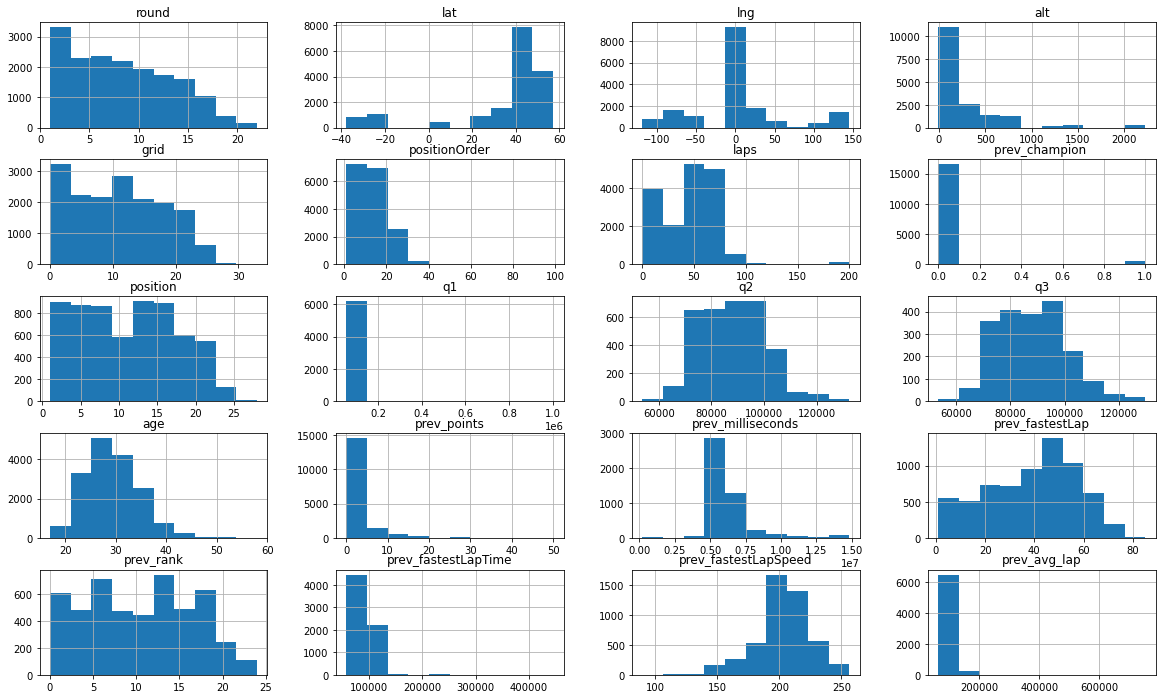

In [36]:
xtra.hist(figsize = (20,12))
plt.show()

In [37]:
xtra.isnull().sum()

round                       0
lat                         0
lng                         0
alt                         0
grid                        0
positionOrder               0
laps                        0
prev_champion               0
position                10750
q1                      10847
q2                      13718
q3                      15029
age                       149
prev_points                 0
prev_milliseconds       12302
prev_fastestLap         10348
prev_rank               12100
prev_fastestLapTime     10348
prev_fastestLapSpeed    12232
prev_avg_lap            10350
dtype: int64

[Back to links](#top)

### Missing Values Imputation <a id="mvi"></a>

In [38]:
for var in ["age"]:    
    IQR = xtra[var].quantile(0.75) - xtra[var].quantile(0.25)
    val = xtra[var].quantile(0.75) + 1.5 * IQR
    xtra[var].fillna(val, inplace = True)
    xtes[var].fillna(val, inplace = True)

In [39]:
xtra = xtra.fillna(0)
xtes = xtes.fillna(0)

[Back to links](#top)

## Model <a id="ai"></a>

In [40]:
def naive_baseline(ytra, ytes):
    # takes the modal class and predicts it to be the result for every row
    from scipy import stats
    mode = stats.mode(ytra)[0] # most frequent
    # print(mode)
    # list of all the predicted values
    tra_pred = [int(mode) for row in ytra.iloc[:]]
    tes_pred = [int(mode) for row in ytes.iloc[:]]
    # calculating score
    from sklearn.metrics import accuracy_score
    tra_score = accuracy_score(ytra,tra_pred) * 100
    tes_score = accuracy_score(ytes,tes_pred) * 100
    return (tra_score, tes_score)

[Back to links](#top)

### Naive Baseline <a id="naive"></a>

In [41]:
naive_baseline(ytra,ytes)

(35.39615564932021, 35.02871205906481)

[Back to links](#top)

### Final Model <a id="rfm"></a>

In [42]:
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 650, random_state = 404)
# Train the model on training data
rf.fit(xtra, ytra)
y_train_preds = rf.predict(xtra)
y_test_preds = rf.predict(xtes)

In [43]:
train_mcc = matthews_corrcoef(ytra,y_train_preds) * 100
test_mcc = matthews_corrcoef(ytes, y_test_preds) * 100

In [44]:
print("train's MCC: {0} % ".format(train_mcc))
print("test's MCC : {0} % ".format(test_mcc))

train's MCC: 99.98367226375512 % 
test's MCC : 72.99163637256456 % 


[Back to links](#top)

# Report <a id="report"></a>

## 1 [Introduction](#1)
   - [1.1 Focus](#1.1)

## 2 [Problem Formulation](#2)
   - [2.1 Background](#2.1)
   - [2.2 EDA](#2.2)
   - [2.3 Prediction Problem](#2.3)
   
## 3 [Wrangling](#3)
   - [3.1 Creation / Deletion](#3.1)
   - [3.2 Merging](#3.2)
   
## 4 [Transformations](#4)
   - [4.1 Missing Values](#4.1)
   - [4.2 Numerical Data](#4.2)

## 5 [Model](#5)
   - [5.1 Algorithm](#5.1)
   - [5.2 Evaluation Metric](#5.2)
   - [5.3 Final Model](#5.3)

## 6 [Summary](#6)
   - [6.1 Further improvements](#6.1)

## Introduction <a id="1"></a>

This report will explore the extracted dataset from the online F1 Database hosted on ["Ergast.com"](http://ergast.com/mrd/), with the intention to create a simple machine learning model from a cleaned and well-prepared data table. Created from 7 different tables taken from the dataset, the report would also document the data wrangling, cleansing and transformation processes performed onto the dataset, with analysis on which methods and techniques used in each step would be most beneficial and logically sound for the final model. For each step, its explanation would be sufficiently supported by findings from data exploration and data understanding where contextual knowledge would be applied.

### Focus <a id="1.1"></a>

The end result of this report would be a well-trained classification model. Used to solve a prediction problem, this model's aim is to predict the possible outcome of a race before it occurs. The possible end status on a race have been categorised into 4 main outcomes : Success, Did not participate/finish, Risk events and Set-Up issues.
The main evaluation metric used throughout the report would be the Matthew's correlation coefficient (MCC) of the dataset used for testing, which showcases the correlation between the true "unknown" values and predicted values. The final model's performance would also be scruntised through [different lens](#5.3), highlighting the best of the model's abilities.

[Back to Table of Contents](#report)

## Problem Formulation <a id="2"></a>

### Background <a id="2.1"></a>

Formula 1 (F1) is often seen as the pinnacle of motorsport, where the best of technology is tested to the limits by the best drivers internationally. Every year, a F1 season is held globally, where the participants travel all over the world racing [the best cars in the different circuits located in all corners](https://www.youtube.com/watch?v=dgfBhZ_9K4k). In a season, the main event at each circuit, known as a [grand prix](https://www.youtube.com/watch?v=SSdsncLXLYs), is held on the final day of the weekend. With [a weekend format](https://www.youtube.com/watch?v=twAlqtvVMdc), the previous day would be the driver's qualifiers, which determines whether they can race the next day and where they start from. 

During the grand prix, points are only awarded to the top 10 drivers based on their finished positions. In the ascending ranking the following points are gained as such: 25, 18, 15, 12, 10, 8, 6, 4, 2, 1. Though, the driver with the fastest lap time completed during the race also gains an additional point.

[Qualifiers](https://www.youtube.com/watch?v=kzsGRhhRr5g) often have 4 rounds, where each round the last 5 gets eliminated from partipating in the next round. The first two to complete all the qualifying rounds and to complete the fastest would get the pole position during the next day's race, which is the very front of the grid and the nearest to the circuit's starting line.

F1 ultimately compromises of 3 main stakeholders: the constructors (people engineering the car), the drivers (people behind the wheel) and the spectators (people behind the stands). Each constructor or team would employ 2 drivers to drive the same car in each grand prix, and the constructors would earn every point their appointed drivers earn from each grand prix. In the season, there are 2 over-arching championships, for the best constructors and the fastest drivers. The spectators on the other hand, at most can benefit financially from this event from placing bets. Otherwise, the spectators themselves do not have any direct impact on the other 2 stakeholders. Possibly an indirect motivation for the constructors, where the top constructors strive to win the championship so as to [uphold their brand image and reputation](https://www.youtube.com/watch?v=SSdsncLXLYs)

Recently, at the [24 July'22 French Grand Prix](https://www.youtube.com/watch?v=gW6r-BPdtN0), a frontrunner voted to win the driver's championship called Charles Leclerc collided when his car went off the track, ultimately labelling his run then as "DNF". This caused ripples within the racing community, on how unfortunate this was considering he attained the pole position and was easily leading in the race before his collision during the 18th lap.

[Back to Table of Contents](#report)

### EDA <a id="2.2"></a>

The dataset given consists of 13 tables, as stated by the data dictionary. This dictionary also states how the primary keys (aka the columns used to join and merge tables) are all internal usage, citing no real meaning behind such numbers. Essentially, this mean that after merging, it is okay to drop such columns especially if there are other ways to identify each row in more meaningful ways. However, this supplementary data dictionary often gave vague column descriptions, warranting a more thorough exploration of each tables' column to identify the meaning and context behind each value.

Overall, it seems that it is possible to group the tables into 4 categories relating to the different aspects and stakeholders involved in F1. This would be: season, constructor, driver, and grand prix.

For the aspect on the F1 season overall, the following tables and their respective column descriptions were identified.

    Circuits
        circuitId : Primary key for internal database use
        circuitRef : Unique identifier used in official settings
        name : Circuit name
        location : Location of the circuit
        country : Host country of the circuit
        lat : Latitude of the circuit
        lng : Longitude of the circuit
        alt : Altitude of the circuit in metres
        url : Url for its wikipedia page
This table itself have no substantial data with direct relation to the race's results, with the features relating to the geospatial location of each circuit being most of interest. It is possible that the altitude of which the grand prix is held at could potentially negatively affect a driver's race. Additionally, the longitude and latitude of each circuits would be a better identifier for each circuit than the columns "circuitId", "circuitRef" and "name". These sets of information could also identify whether certain cicruits are held within the same country. After all, it can be argued that the next race being held in the same country as the previous race would not negatively affect the drivers (e.g jet lag) and in turn their performance.

    Seasons
        year: Year of which the season held on
        url : Url for that year's season wikipedia page
Overall, this table does not provide a lot of data at first glance. To extract the most from these 2 columns, web scraping can be done to extract more information from the "url" here, but that could potentially introduce unnecessary and redundant data. Out of fear doing so could possibly lead to data leakage, this table have been slated not to be used for the final table.

For the aspect on the participating constructors, the following tables and their respective column descriptions were identified.


    Constructors
        constructorId : Primary key for internal database use
        constructorRef : Unique identifier used in official settings
        name : Name of the constructor (Company / Division name)
        nationality : Constructor's host country
        url : Url for its wikipedia page
By itself, this table does not offer a lot of value since it seems it serves to identify each constructor's name. Even the nationality do not offer much interest since the country the company was founded in should not have an effect on the grand prix's results.

    Constructors_standings
        constructorStandingId : Primary key for internal database use
        raceId : Foreign key link to the tables related to the grand prix
        constructorId : Foreign key link to the "Constructors" table
        points : Total amount of points earned by their drivers
        position : Rank amongst the constructors in each race
        positionText : "position" but with status on the ranking
        wins: Number of their drivers attaining first so far in the season
    Constructors_results:
        constructorResultsId : Primary key for internal database use
        raceId : Foreign key link to the tables related to the grand prix
        constructorId : Foreign key link to the "Constructors" table
        points : Same as "points" in "Constructors_standings"
        status : results' status / reason behind NaN values for 'points'
These two tables' data tally with each other, where the points are the same. For the "Constructors_standings" the data is more focussed on how the constructors fare against each other, which would have the most relevant data on the constructor's championship. The "Constructors_results" table focussed on the races' result, which can be derived from the "Results" table too. Overall, it seems that these 2 tables do not introduce any new information compared to the other tables in the dataset.

For the aspect on the participating drivers, the following tables and their respective column descriptions were identified.

    Drivers
        driverId : Primary key for internal database use
        driverRef : Unique identifier used in official settings
        number : Number chosen to represent themselves (1 is reserved)
        code : Unique code used in offical settings (for broadcasting)
        forename : Driver's first name
        surname : Driver's family name
        dob : Driver's date of birth (dd/mm/yyyy)
        nationality : Driver's nationality
        url : Url for its wikipedia page
The column "number" is most interesting, since 2014 drivers are allowed to choose a representative number for themselves. However, the number 1 was reserved for the previous season's champion, for example Max Verstappen being the 2021 world champion and having the number 1 for 2022. Another interesting column would be "dob", where the age of the drivers during the race could potentially negatively affect their performance.

    Driver_standings
        driverStandingsId: Primary key for internal database use
        raceId : Foreign key link to the tables related to the grand prix
        driverId : Foreign key link to the "Drivers" table
        points : Total points earned so far in each season
        position : Rank amongst the drivers in each race
        positionText : "position" but with status on the ranking
        wins : Number of wins from attaining first so far in each season
In a sense, this table is just another perspective on the data presented in the "Constructors_standings" table, where the points from the races are instead grouped by the drivers that earned them instead. Thus, in the same essence, this table seems unnecessary.

For the aspect on the details of each grand prix, the following tables and their respective column descriptions were identified.

    Pit_stops
        raceId : Foreign key link to the "Races" / "Results" table
        driverId : Foreign key link to the "Drivers" table
        stop : Number of stops taken so far by the driver during a race
        lap : Lap number
        time : Timestamp of when the pit stop occurred (in 24hr format)
        duration : Time spent at the pit stop
        milliseconds : "duration" but in milliseconds (more accurate)
Despite the importance of having pit stops during a race, this table is awfully limited in terms of information, with the earliest data dating back from 2011. This limited range made the table unappealing to use, since the other tables at least have data from earlier races and merging them together could warrant unnecessary NaN values.

    Lap_times
        raceId : Foreign key link to the "Races" / "Results" table
        driverId : Foreign key link to the "Drivers" table
        lap : Lap number 
        position : Driver's position during the lap
        time : Time taken for the lap
        milliseconds : "time" but in milliseconds (more accurate)
        
Information about each laps' timings and the driver's position would not be known before the grand prix starts. Thus, the model should utilise the driver's previous race's performance, for example the previous races' average timing taken for a lap or the fastest timing for a lap. Taking the average of the driver's positions during the previous race felt unnecessary, since the timings can already provide such information when sorted. 

    Qualifying
        qualifyId : Primary key for internal database use
        raceId : Foreign key link to the "Races" / "Results" table
        driverId : Foreign key link to the "Drivers" table
        constructorId : Foreign key link to the "Constructors" table
        number : Number chosen to represent themselves (1 is reserved)
        position : End position attained from the race's qualifiers
        q1 : Total time clocked for the qualifiers' round 1
        q2 : Total time clocked for the qualifiers' round 2
        q3 : Total time clocked for the qualifiers' round 3
As data collected from the day before the grand prix, this table definitely needs to be considered to be used in the final data table. Here, for each round drivers would get eliminated, preventing them from participating in the next round and ultimately resulting in NaN values for the rounds. Rather than dropping the rows where the driver may not have made it through all the rounds, it may be best to replace all the missing values with a 0, representing how the drivers did not even get to participate in those rounds.

    Races
        raceId : Primary key for internal database use
        round : Round number for the race in its season
        circuitId : Foreign key link to the "Circuits" table
        name : Name of the race
        date : Date of when the race is held on
        time : Time of when the race starts (in 24hr format)
        url : Url for its wikipedia page
As a fact table, the most interesting and useful column here would be the "date", specifically the year the round is held on.

    Results
        resultId : Primary key for internal database use
        raceId : Foreign key link to the "Races" table
        driverId : Foreign key link to the "Drivers" table
        constructorId : Foreign key link to the "Constructors" table
        number : Same as "number" in "Qualifying"
        grid : Starting position (taken from "position" from "Qualifying")
        position : Ending position attained by the driver
        positionText : "position" but with status on the race's results
        positionOrder : "position" but all drivers received a number 
        points : Number of points earned from the race
        laps : Number of laps completed by the driver during a race
        time : Total time taken / Time gap from the 5th  when finishing
        milliseconds : "time"  but in milliseconds (more accurate)
        fastestLap : Lap number of which the fastest timing was attained
        rank : Rank number among the drivers' fastest lap timing
        fastestLapTime : Timing for the driver's fastest lap
        fastestLapSpeed : Speed (km/h) for the driver's fastest lap
        statusId : Foreign key link to the "Status" table
After considering the above tables, using a composite key of ("raceId","driverId") offers more use than utilising only one. Since a race would have multiple drivers and a driver can compete in multiple races, but a driver can only compete in a certain race once, making the composite key a reliable unique identifier for each row instead of only using one of these features ("resultId", "raceId", "driverId").
Most of these information are gathered after the race is finished, so to retain the wealth of data given by this table, new columns should be created to contain the drivers' performance in their previous race. 
Aditionally, "positionOrder" is practicallya number given to all the drivers based on their finishing positions, regardless if the driver even completed the race.

    Status
        statusId : Primary key for internal database use
        status : Finishing status / reason behind the failed race
Looking through this fact table, all the status seems to be able to be grouped into 4 categories: Finished, did not qualify or finish, risky events often caused by the drivers during the race, and issues with the car's set-up. 
A common status seen would be the +_ laps, which refers to the number of laps left for the driver to finish after the top 10 placements have been decided. 

[Back to Table of Contents](#report)

### Prediction Problem <a id="2.3"></a>

After considering carefully the extent of detail given by each table from the dataset, the column "status" in the table "status" felt the most interesting and important feature in the whole dataset. Towards the constructors and drivers involved in the grand prix, predicting the outcome of the race could give them confidence in their race or could even warn them on whether there could be potential issues with the car's set-up or accidents occuring on the race track. 

Thus, it was decided that this report's simple machine learning model aims to predict the outcome of the race, by considering the drivers' past performance and the race's different attributes. 

[Back to Table of Contents](#report)

## Wrangling <a id="3"></a>

### Creation / Deletion <a id="3.1"></a>

The following creation and dropping of features were all done in consideration of the [EDA done earlier](#2.2). 

For the "results" table, the column "number" was effectively re-encoded into another columns called "prev_champion" to represent whether the driver was the previous season's champion. This is done by checking whether the "number" is 1, which is the reserved number for the crowned champion for the previous F1 season. Afterwards, the "fastestLapTime" column were transformed and cleaned to represent the timing in milliseconds rather than in the "MM:SS" format. Lastly, the redundant columns ("time", "number", "position", "positionText") were dropped. The column "positionOrder" was retained, with the intention to allow the users of the model to enter in a rough gauge on the driver's finishing position for the race they want to predict the outcome for. Especially since the number assigned to the driver may not necessarily reflect their performance during a race (e.g. getting assigned a number despite not competing).

For the "status" table, the "target" feature was created by checking if the status description falls under the 4 possible outcomes : Success, Did not finish / participate, Risk events or Set-up issues. Only after being merged into the final table will the two columns "statusId" and "status" be dropped. These descriptions are categorised on whether the driver finished successfully, the driver did not participate or had a couple of laps left to go, the driver had an risky encounter / accident on the race track, or the driver's car encountered issues with its technical parts / machinery. For a more detailed dive into the classification of the status, refer to the function [create_target](#dw) and the lists inside the code block.

For the "qualifiers" table, all of the columns related to the timings completed for each qualifying round were cleaned and transformed to be in milliseconds instead of the "MM:SS" format. 

The same was applied to the column "time" in the table "laps", as the column values would be similar in precise the timings are in the "results" table. Using the "milliseconds" column instead would be more accurate, but it is not as favourable to be used for [imputing missing values later](#fillna). Additionally, this table was used to aggregate the data into two different groups, one for the minimum lap timing for each driver's race (essentially their fastest lap), another for the average timing taken for a lap during a driver's race. The former group is meant for cross-validating and filling in the missing values of the "results" table, whereas the latter group will be used to add in 1 more feature into the final table. The idea behind the latter group's usage is that the average timing for a lap could give another layer of information on the driver's past performances in races.

For the "drivers" table, the column "dob" was typecasted to the appropraite 'datetime' data type, which would facilitate an easier creation of another column after merging. This columns would be the driver's age during each of their races.

Lastly, the "races" table were cleaned up to have their "dates" be more plausible, as opposed to races supposedly occurring on dates like "4/5/12009" or "10/29/12017".

[Back to Table of Contents](#report)

### Merging <a id="3.2"></a>

Overall, the common columns in most of the chosen tables would be ("driverId", "raceId"). This composite key was used in merging the following tables with the "results" table : "qualifiers", "average_L", "fastest_L". The other tables were combined using the fact table's primary key, for example, "circuitId" in "circuits", "raceId" in "races", "driverId" in drivers, and "statusId" in "status". Afterwards, all of these identifier columns were dropped since such values do not have any intrinsic meaning behind its numbers aside from identifying the rows.

Some of the columns merged into the main table were only meant to help with filling in [missing values](#fillna) for certain columns. After imputation, these columns were dropped, since its purpose have been fulfilled. Also doing so would reduce the table's dimensionality, hopefully improving the speed of building the final model.

In the end, this resulted in a final merged table being used for model building, so the following will showcase their columns and where they came from.

<table>
  <caption>Columns in df</caption>
  <tr>
    <th>Table taken from</th>
    <th>Column Names</th>
  </tr>
  <tr>
    <td>races</td>
    <td>round</td>
  </tr>
  <tr>
    <td>circuits</td>
    <td>lat, lng, alt</td>
  </tr>
    <tr>
    <td>drivers / races</td>
    <td>age</td>
  </tr>
  <tr>
    <td>laps</td>
    <td>prev_avg_lap</td>
  </tr>
  <tr>
    <td>qualifiers</td>
    <td>q1, q2, q3</td>
  </tr>
  <tr>
    <td>status</td>
    <td>target</td>
  </tr>
  <tr>
    <td>results</td>
    <td>grid, positionOrder, laps, prev_champion, prev_points, prev_milliseconds, prev_fastestLap, prev_rank, prev_fastestLapTime, prev_LapSpeed</td>
  </tr>
</table>

After creating a dataframe with 20 columns and 24 378 rows of data, the dataset will be split into 2 sets with the proportions of 3:7, one being for testing and the other used for training the model respectively. Moving forward, whatever transformations done onto the train dataset will also be applied onto the test dataset.

[Back to Table of Contents](#report)

## Transformation <a id="4"></a>

In the merged table, the following columns were pinpointed to be information that cannot be known before a race starts: "points", "milliseconds","fastestLap", 'rank', "fastestLapTime", "fastestLapSpeed", "avg_lap".

These columns then underwent a "lag shift", which created columns where all the values were just shifted down 1 row after the table were sorted by "driverId" and "date" of the race (since the "driverId" is not labelled chronologically). These new columns are used to refer to the driver's performance in the previous race the driver attended. Afterwards, all the rows on a driver's first race were dropped due to this "lag shift".

### Missing Values <a id="4.1"></a>

Even before merging the tables into one, the missing values in the table "circuits" were imputed with the corresponding values found online. Since it is more efficient to impute 2 missing records than to impute every "alt" record every time the race is held at certain circuits.

In the merged data table<a id = "fillna"></a>, there is still 168917 NaN values left. However, it is possible to use data from other columns to retrieve or calculate the right value for the missing values. For example, from the "Laps_time" table the fastest lap timing can be aggregated according to each race for each driver. Extracting this information would then be used to impute the corresponding missing values for the "fastest_Lap" and the "fastest_LapTime". Doing so would replace 2767 and 2768 missing values respectively, leaving the other NaN values in those columns blank still.

The columns still containing such NaN values mostly is due to the fact that the driver may have not participated or finished the previous race or all the qualifying rounds, resulting in a blank value for them. Thus, it is logically sound to continue treating such missing values as "a no show" or "did not happen" by imputing the missing values with 0, indicating how in a sense the race/qualifiers did not occur. Afterwards, only one column ("age") is left with missing values.

Thus, mutliple trials were ran to decide which imputation method would yield the highest MCC for the random forest model, where each model has 835 estimators / trees. 

<table>
  <caption>Imputation Methods' MCC Results in % </caption>
  <tr>
    <th></th>
    <th>Mean</th>
    <th>Median</th>
    <th>Mode</th>
    <th>End Tail</th>
    <th>Constant (0)</th>
  </tr>
  <tr>
    <th>Train</th>
    <td style="background-color:#FFFFBF">99.98367226375512</td>
    <td style="background-color:#FFFFBF">99.98367226375512</td>
    <td style="background-color:#FFFFBF">99.98367226375512</td>
    <td style="background-color:#FFFFBF">99.98367226375512</td>
    <td style="background-color:#FFFFBF">99.98367226375512</td>
  </tr>
  <tr>
    <th>Test</th>
    <td>72.48023964963538</td>
    <td>72.4466447732789</td>
    <td>72.67337812216668</td>
    <td style="background-color:#FFFFBF">72.70294080037132</td>
    <td>72.47900395466822</td>
  </tr>
</table>


As seem from the above, imputing the missing values with the higher outlying value found in the age's distribution seems reasonable, as it greatly improves the model's performance.

[Back to Table of Contents](#report)

### Numerical Data <a id="4.2"></a>

Considering the principles behind the random forest model, it seems [unnecessary to mathematically transform or scale the dataset](https://stats.stackexchange.com/questions/58697/when-to-log-exp-your-variables-when-using-random-forest-models), since the algorithm is not based off euclidean distance (distance between each data point plotted) and does not benefit from normally distributed features. Thus, no correction or changes should be done onto the features just to attain a gaussian distribution. Doing so unnecessarily ultimately changes the data values, a rather needless action. Additionally, none of the outliers in every columns seems improbable but in fact sound logical, considering the context behind each race.

As such, the only techniques used in transforming the dataset would be discretization.

In this rather "brute-force" process, 1 048 575 combinations were made from the 20 features present, and during the trials, each combination of features would be discretized into bins of either equal frequency or width. Afterwards, a random forest model would be trained from that dataset and be evaluated through its MCC. For every trial, the random forest model is set to have 835 trees each time, using the same random seed.

For the method of binning by frequency, only 34 631 / 1 048 575 of the possible feature combinations were tested, while for the method of binning by width, only 46 897 combinations were tested. Not all could have been tested due to time constraints (approximately ~12 days) and the machine's memory constraint (would require more than 16gb RAM).

<table>
  <caption>Discretization' MCC Results in % </caption>
  <tr>
    <th>no.</th>
    <th>Features</th>
    <th>Type</th>
    <th>Method</th>
    <th>Train's MCC</th>
    <th>Test's MCC</th>
  </tr>
  <tr>
    <th>4</th>
    <td >'lat', 'laps', 'position', 'age', 'prev_points'</td>
    <td > By Freq </td>
    <td >Struge's v2</td>
    <td >99.98367226375512</td>
    <td>72.48023964963538</td>
  </tr>
  <tr>
    <th>4</th>
    <td >'lat', 'laps', 'position', 'age', 'prev_points'</td>
    <td > By Freq </td>
    <td >Freedman</td>
    <td >99.97550908061218</td>
    <td>71.75444370018735</td>
  </tr>
  <tr>
    <th>4</th>
          <td >'q3', 'prev_points', 'prev_milliseconds', 'prev_rank'</td>
    <td > By Freq </td>
    <td >Struge's v2</td>
    <td >99.98367226375512</td>
    <td>72.34796603973713</td>
  </tr>
    
  <tr>
    <th>5</th>
          <td >'alt', 'q3', 'age', 'prev_fastestLap', 'prev_fastestLapTime'</td>
    <td > By Freq </td>
    <td >Struge's</td>
    <td >99.98367226375512</td>
    <td>72.55652440292747</td>
  </tr>
  <tr>
    <th>5</th>
          <td >'grid', 'q2', 'q3', 'age', 'prev_avg_lap'</td>
    <td > By Freq </td>
    <td >Struge's </td>
    <td >99.98367226375512</td>
    <td>72.27999745431923</td>
  </tr>
  <tr>
    <th>5</th>
          <td >'lat', 'prev_fastestLap', 'prev_rank', 'prev_fastestLapSpeed', 'prev_avg_lap'</td>
    <td > By Width </td>
    <td >Freedman</td>
    <td >99.98367226375512</td>
    <td>72.62203623992446</td>
  </tr>
  <tr>
    <th>5</th>
          <td >'lng', 'grid', 'q2', 'age', 'prev_fastestLapTime'</td>
    <td > By Width </td>
    <td >Struge's  </td>
    <td >99.98367226375512</td>
    <td>72.36551054496694</td>
  </tr>
  <tr>
    <th>6</th>
          <td >'lat', 'age', 'prev_fastestLap', 'prev_rank', 'prev_fastestLapSpeed', 'prev_avg_lap'</td>
    <td > By Width </td>
    <td >Freedman</td>
    <td >99.98367226375512</td>
    <td>72.62203623992446</td>
  </tr>
  <tr>
    <th>6</th>
          <td >'lat', 'position', 'prev_fastestLap', 'prev_rank', 'prev_fastestLapSpeed', 'prev_avg_lap'</td>
    <td > By Width </td>
    <td >Freedman</td>
    <td >99.98367226375512</td>
    <td>72.62203623992446</td>
  </tr>
  <tr>
    <th>6</th>
          <td >'lat', 'position', 'age', 'prev_fastestLap', 'prev_fastestLapSpeed', 'prev_avg_lap'</td>
    <td > By Width </td>
    <td >Freedman</td>
    <td >99.98367226375512</td>
    <td>72.62203623992446</td>
  </tr>
</table>

The table has shown that even the top 10 discretizated dataset delivered a worser model performance than a model trained by an undiscretized dataset (test MCC of 72.70294080037132 %). As such, none of the features in the dataset should be discretized.

[Back to Table of Contents](#report)

## Model <a id="5"></a>

### Algorithm <a id="5.1"></a>

The chosen algorithm for the machine learning model was originally the [Random Forest Classifier](https://towardsdatascience.com/understanding-random-forest-58381e0602d2), which works by having an ensemble of individual decision trees operating independently spit out predictions and taking the most common prediction as the answer. Through the wisdom of crowds, the idea is that a large number of trees with low correlations to each other operate independently together will outperform any other individual tree.

[Additionally](https://builtin.com/data-science/random-forest-algorithm), the random forest classifier algorithm has a built-in dimensionality reduction feature, where a constituent tree would search for the best feature from a subset of features. Also, the number of trees do not affect the chances of overfitting, a common issue faced when building machine learning models.

The model was originally chosen to use this algorithm, but more trials were done where the model utilised a [different classification algorithm](https://www.javatpoint.com/classification-algorithm-in-machine-learning#:~:text=The%20Classification%20algorithm%20is%20a,number%20of%20classes%20or%20groups.). 3 of the most common algorithms were chosen and their respective model's performance is shown below:

<table>
  <caption>Algorithms behind Models' MCC Results in % </caption>
  <tr>
    <th>Algorithm</th>
    <th>Solver / Type</th>
    <th>Train</th>
    <th>Test</th>
  </tr>
  <tr>
    <th>Logistic Regression</th>
    <td>lbgfs</td>
    <td>22.5383976878983</td>
    <td>22.803462116472915 </td>
  </tr>
  <tr>
    <th></th>
    <td>newton-cg</td>
    <td>44.69723943502344</td>
    <td>44.19072098625655</td>
  </tr>
  <tr>
    <th></th>
    <td>liblinear</td>
    <td> - </td>
    <td> - </td>
  </tr>
  <tr>
    <th></th>
    <td>sag</td>
    <td>22.577579038604927</td>
    <td>22.577579038604927</td>
  </tr>
  <tr>
    <th></th>
    <td>saga</td>
    <td>22.541425519661047</td>
    <td>22.81986384387709</td>
  </tr>
  <tr>
    <th>Decision Tree</th>
    <td>  </td>
    <td>100.0</td>
    <td>58.52082450085031 </td>
  </tr>
  <tr>
    <th>Naive Bayes</th>
    <td> Gaussian </td>
    <td>19.61929024449286</td>
    <td>20.026483158767665 </td>
  </tr>
  <tr>
    <th></th>
    <td>Bernoulli</td>
    <td>23.735326390101875</td>
    <td>23.390927104681843</td>
  </tr>
  <tr>
    <th></th>
    <td>Multinomial</td>
    <td> - </td>
    <td> - </td>
  </tr>
  <tr>
    <th></th>
    <td>Complement</td>
    <td> - </td>
    <td> - </td>
  </tr>
  <tr>
    <th></th>
    <td>Categorical</td>
    <td> - </td>
    <td> - </td>
  </tr>
</table>


As expected, the random forest classifier performed the best, which validate the decision to use the algorithm from the start. However, all of these models had the same training dataset, which could explain their poor performance. After all, the dataset were wrangled, cleaned, and transformed to suit the random forest algorithm the best.

In all the previous trials done throughout each cleansing and transformation process, the random forest classifier was set to have 835 trees when evaluating effectiveness of each process. However, to ensure that 835 is the most suitable number of trees to be used for the random forest model, another trial was done. During this, 400 models were built and evaluated, where the number of trees used in each ranged from 5 to 2 000 in steps of 5. The following table consolidates the trial's results and showcases the top 5 models, inclusive of the model used throughout the report in comparison.

<table>
  <caption>Top 5 Models' MCC Results in % </caption>
  <tr>
    <th>no.</th>
    <th>Train</th>
    <th>Test</th>
  </tr>
  <tr>
    <th>645</th>
    <td>99.98367226375512</td>
    <td>72.91453222439853 </td>
  </tr>
  <tr>
    <th style="background-color:#FFFFBF">650</th>
    <td>99.98367226375512</td>
    <td style="background-color:#FFFFBF">72.99163637256456</td>
  </tr>
  <tr>
    <th>655</th>
    <td>99.98367226375512</td>
    <td>72.99024955250945</td>
  </tr>
  <tr>
    <th>660</th>
    <td>99.98367226375512</td>
    <td>72.91428634848909</td>
  </tr>
  <tr>
    <th>835</th>
    <td>99.98367226375512</td>
    <td>72.70294080037132</td>
  </tr>
</table>


As seen from above, the model could perform much better when using 650 decision trees instead of 835.

[Back to Table of Contents](#report)

### Evaluation Metric <a id="5.2"></a>

As the model is trained to do [multiclass classification](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd), evaluating its performance solely on its accuracy score is not enough. This is due to the nature of multiclass prediction, where there is a distinction among true positives, true negatives, false positives, and false negatives. 

A true positive (TP) value is where the predicted value corresponds to the true "desired" value correctly, as compared to a false positive (FP) value being where the predicted value does not correspond to the true "desired" value (the model is meant to predicted the "undersired" outcome instead). The same line of thinking is applied onto the distinction between a true negative (TN) and a false negative (FN) , where the negative aspect is referring to an "undesired" outcome. This can also be visualised by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

For this report, the most desired outcome would be the "Success", so this prediction problem would be approached as One-vs-Rest (OVR), where the evaluation metrics find its own class as desirable and the rest undesirable.

As compared to binary classification where there is only true or false, multiclass metrics need to evaluate and weigh each class's accuracy through different methods or formulas. This results in multiple facets for a model to be evaluated.

However, for comparing models, it is ideal to use a single number, instead of 1 number of each class. This can either be achieved through using an averaged score / metric or a calculated value considering the different attributes or performance scores for a model.

Two averaging techniques are as follows:
    
    Macro
        simple arthemetic mean of the metric across all classes
    Weighted
        takes the average of the metric weighted by each class's size
        
These techniques are often applied to a model's precision, recall and F1 score values. The usage and calculation for each metric is as such:

    Precision
        proportion of predicted positives that are truly positive
        = TP / (TP + FP)
    Recall
        proportion of actual positives that are correctly predicted
        = TP / (TP + FN)
    F1 Score
        harmonic mean of the precision value and the recall value
        = (2 x Precision x Recall) / (Precision + Recall)
        
However, these values all only looks at one aspect of the model's performance at a time, making it quite unreliable. Additionally, using F1 score works best when there is a class imbalance. In this report, there is no major disparity between the number of rows for each class, rendering the F1 score irrelevant.

Another common metric used would be the Area Under the Receiver Operating Characteristic Curve (ROC AUC / AUROC), quantifying the model's ability to distinguish between each outcome. However, a higher number does not necessarily mean a better model. Thus, this metric is not considered in this report. 

Unfortunately, even though the classifier would not experience a class imbalance, using accuracy score is not a fair evaluation of the classifier. Luckily, there is a single-number alternative to accuracy which calculates the correlation between true values and the predicted outcomes. This is called Matthew's correlation coefficient (MCC) - the evaluation metric used throughout this report. It is calculates as such:

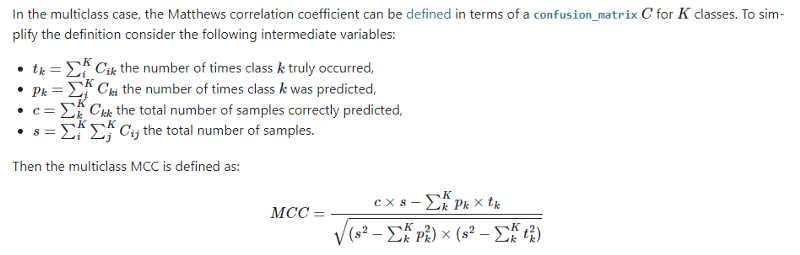

Often [cited](https://www.youtube.com/watch?v=m_gfjun6XJw) to be the best scoring system to measure the performance of a mutliclass classifier, this evaluation metric was ultimately chosen to be the main metric used throughout this report.

[Nonetheless](https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56), the final model will still be evaluated through other metrics, to give the users more confidence in the classifier's prediction. Additionally, a confusion matrix will be visualised in a heatmap to showcase the proportion of predictions for each outcome by each true value.

[Back to Table of Contents](#report)

### Final Model <a id="5.3"></a>

With a training dataset with 17 064 rows and 20 features, the model was built using the random forest classifier with 650 constituent decision trees. The graph will showcase the importance of each feature to the model, highlighting the features with the biggest impact on the model.

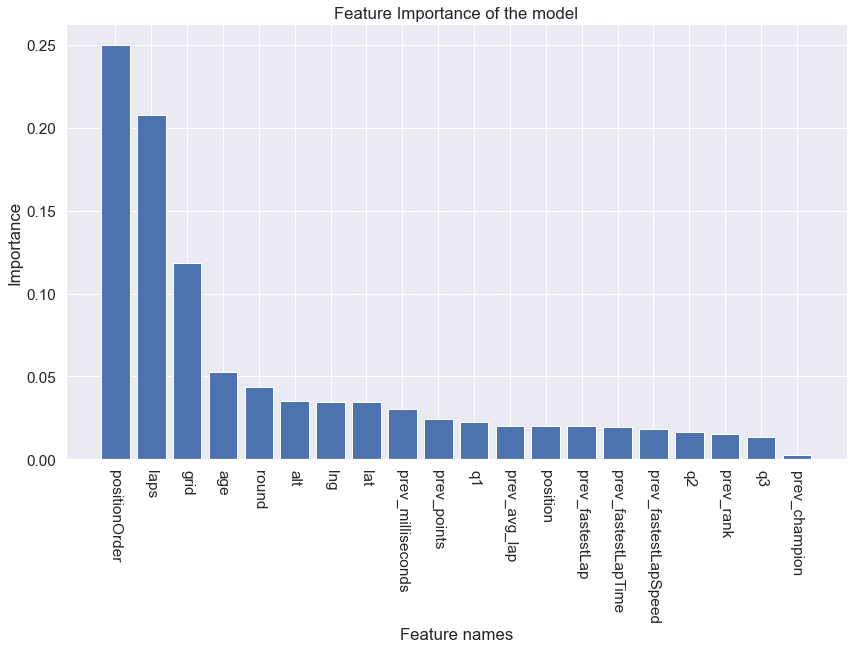

Seeing how all the features used in the model and contributes to its performance, this is enough to support the creation of the columns earlier and combination of  all the different table's columns into the final merged table.

Compared to the naive baseline model built, the final model fared much better in terms of accuracy score, which can be seen in the below table.

<table>
  <caption>Final Model's vs Naive Baseline's Accuracy in % </caption>
  <tr>
    <th></th>
    <th>Naive Baseline</th>
    <th>Final</th>
  </tr>
  <tr>
    <th>Train</th>
    <td>35.39615564932021</td>
    <td>100.0</td>
  </tr>
  <tr>
    <th>Test</th>
    <td>35.02871205906481</td>
    <td>81</td>
  </tr>
</table>

These values are extracted from the following code block, which utilises the metrics mentioned earlier.

In [45]:
# for a clearer understanding of the model's performance
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(ytes, y_test_preds))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2015
           1       0.84      0.86      0.85      2562
           2       0.64      0.32      0.43       809
           3       0.73      0.84      0.78      1928

    accuracy                           0.81      7314
   macro avg       0.77      0.73      0.74      7314
weighted avg       0.80      0.81      0.80      7314



 Overall, this model seems to perform well, except for predicting the outcome "Risk events". This can be further scruntized in the following heatmap, showcasing how the model may have difficulties differentiating the differences between the class "Risk events" and "Set-up issues".

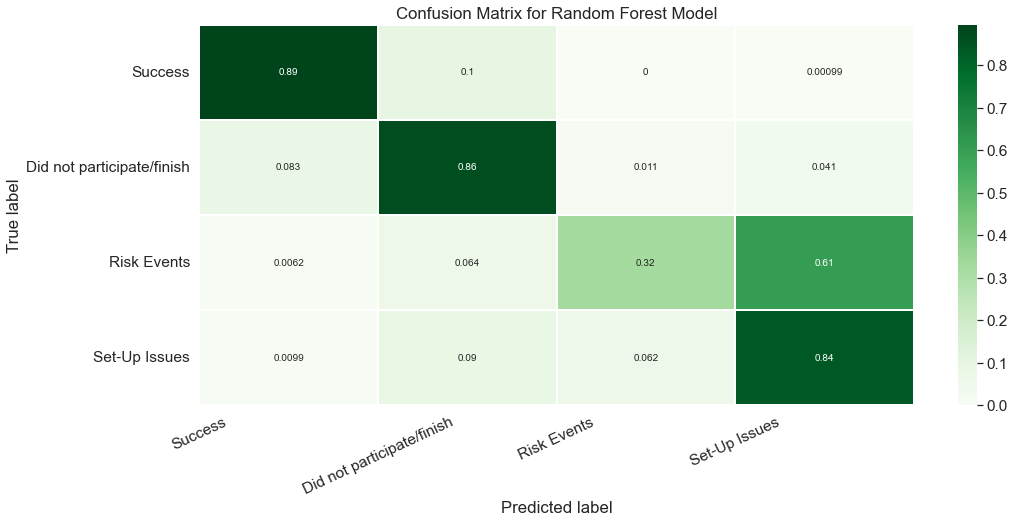

Nonetheless, the final model is evaluated to perform quite well, being reliable in predicting whether a race would end successfully or not. If the race does not end as a success, the model could also predict a vague reason why, reliably citing it to be either due to the driver or the car's machinery.

[Back to Table of Contents](#report)

## Summary <a id="6"></a>

At its best, the model can perform as such:

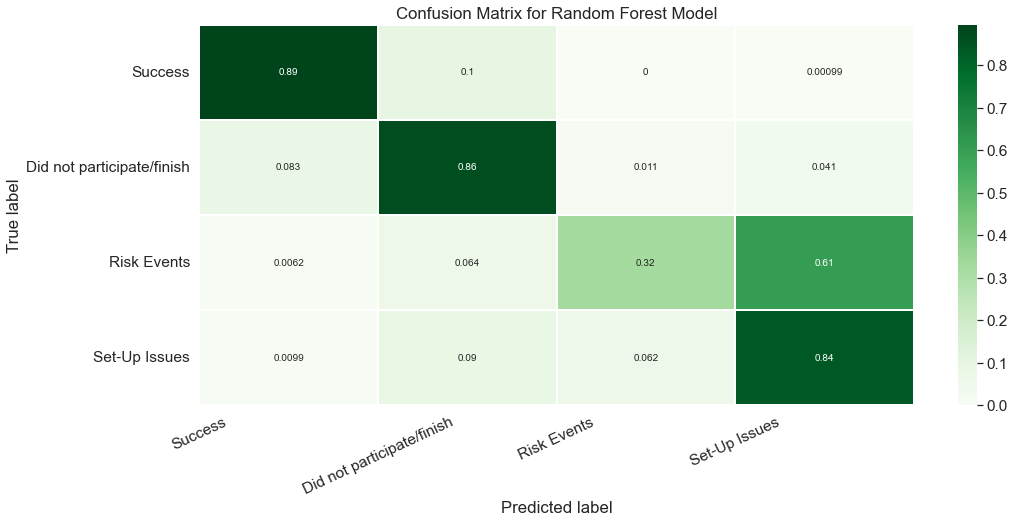

This is attained by
- loading in the tables "results", "status", "qualifiers", "laps", "drivers", "races", "circuits"
- cleaning all the columns relating to timing to be in milliseconds instead
- using the "laps" table to find the fastest lap timings and corresponding lap number
- using such numbers to impute corresponding missing values in "results"
- getting the average lap timing for each driver's race from "laps"
- calculating the driver's age during each race
- personally imputating missing values in "circuits" based on contextual knowledge
- merging all the tables together
- dropping irrelevant and identifier columns
- creating lagged columns by shifting the previous race's statistics in front
- imputing missing "age" values with outlying values found at the end-tail
- imputing the rest of NaN values with 0


### Further Improvements <a id="6.1"></a>

Regardless, there are still more avenues to explore for a possibly better model.

Some suggestions would include:
- use web scraping to extract more data from the urls
- employ Natural Language Processing (NLP) techniques on extracted text data
- use information relating the constructor
- explore using categorical data with different encoding methods
- create more calculated columns from the given columns
- check if the driver is native to the circuit's host country
- create more classes (hopefully more distinct) for the target variable
- consider the number of pit stops and its statistics for each driver's race
- include the constructor's or the driver's standings at that point of the season
- using an Artifical Neural Network (ANN) instead for prediction
<br>
etc.

[Back to Table of Contents](#report)